## Whole brain calcium imaging data from C. elegans, Kato et al. 2015

Kato, S., Kaplan, H. S., Schrödel, T., Skora, S., Lindsay, T. H., Yemini, E., et al. (2015). Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

AVA_HisCl.mat	     TestData.ipynb  WT_NoStim_pre73.mat
readme_Kato2015.txt  WT_NoStim.mat   WT_Stim.mat
Contents of MAT file WT_Stim.mat: ['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw']
<HDF5 dataset "b": shape (107, 2198), type "<f8">
[[ 7.47389950e-02  3.62857489e-02  1.00580179e-01 ...  1.02936506e-02
  -2.83354128e-05 -1.20249083e-03]
 [ 2.00346986e-01  1.98421232e-01  1.69068908e-01 ... -1.79144239e-02
   8.30023986e-03 -4.07311743e-02]
 [ 2.39662235e-01  2.22966827e-01  2.20374255e-01 ... -6.90258393e-02
  -8.55001612e-02 -9.16157880e-02]
 ...
 [ 9.96826055e-02  9.14201523e-02  1.04708007e-01 ... -4.93049514e-02
  -3.49219059e-02 -5.98756234e-02]
 [ 2.37984137e-01  2.40762932e-01  2.16524245e-01 ... -8.76862361e-02
  -1.12739208e-01 -1.08623962e-01]
 [ 3.33837295e-01  3.05943779e-01  2.81912524e-01 ...  9.89681095e-03
  -1.06773536e-02  3.48015477e-02]]
[ 7.47389950e-02  3.62857489e-02  1.00580179e-01 ...  1.02936506e-02
 

/home/padraig/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/padraig/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/padraig/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/padraig/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:77: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/padraig/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:90: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/padraig/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:98: H5pyDeprecationWarning: dataset.value has been depre

ID: [<HDF5 object reference>] (<class 'numpy.ndarray'>)
Plotting cell 23: OLQVR
ID: [<HDF5 object reference>] (<class 'numpy.ndarray'>)
Plotting cell 24: OLQVL


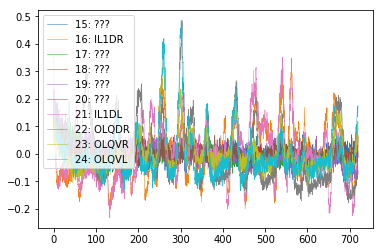

In [23]:
!ls

import matplotlib.pyplot as plt
%matplotlib inline 

import h5py
import numpy as np
import scipy.io as sio



all_datarefs = ['WT_Stim']

for data_ref in all_datarefs:
    
    mat_file = '%s.mat'%data_ref
    h5_file = h5py.File(mat_file, 'r')
    mat_contents = h5_file[data_ref]


    print('Contents of MAT file %s: %s'%(mat_file, sorted(mat_contents.keys())))
    
    '''
    From readme:
    
    traces_raw= neural activity traces uncorrected
    traces = neural activity traces corrected for bleaching
    tracesDif = derivative of traces
    IDs = identified neuron IDs
    timeVectorSeconds = time vector in seconds
    fps = frames per second
    dataset = name of dataset
    stimulus
        -identity = what was changed e.g. O2 (oxygen)
        -type = stimulus type e.g. binary steps
        -switchtimes =  time in seconds when stimulus changed from initial state to the other state
        -initialstate = the state that the stimulus starts with, refers to "conc"
        -conc = the concentrations of the stimulus
        -concunits - units of the "conc"

    States = vector of different state types (8 states for WT_NoStim, 4 states for WT_Stim and AVA_HisCl

    8 states for WT_NoStim:
        ‘FWD’ forward crawling; ‘SLOW’ forward slowing; ‘DT’ dorsal post reversal turn
        ‘VT’ ventral post reversal turn; ‘REV1’ reverse crawling;
        ‘REV2’ reverse crawling; ‘REVSUS’ sustained reverse crawling; ‘NOSTATE’ - ambiguous

    4 states for WT_Stim and AVA_HisCl:
        ‘FWD’ forward crawling; ‘REV’ reverse crawling
        ‘REVSUS’ sustained reverse crawling; ‘TURN’ post reversal turn
    '''
    
    
    key_set = sorted(mat_contents.keys())
    traces_raw_h5ref = mat_contents['traces_raw']
    traces_raw = h5_file[traces_raw_h5ref[0][0]]
    print(traces_raw)
    print(traces_raw.value)
    print(traces_raw.value[0])
    
    print('time vector: ')
    timeVectorSeconds_h5ref = mat_contents['timeVectorSeconds']
    timeVectorSeconds = h5_file[timeVectorSeconds_h5ref[0][0]]
    print(timeVectorSeconds)
    print(timeVectorSeconds.value)
    
    
    fps = np.array(mat_contents['fps'])
    print(h5_file[fps[0][0]])
    
    print('IDs of cells: ')
    IDs_h5ref = mat_contents['IDs']
    IDs = h5_file[IDs_h5ref[0][0]]
    print(IDs)
    #print(IDs.value)
    print(IDs[0])
    print(h5_file[IDs[0][0]].value)

    
    
    plt.figure()
    id = '???'
    for i in range(15,25,1):
        id = h5_file[IDs[i][0]].value[0]
        print('ID: %s (%s)'%(id, type(id))) 
        if not type(id)==np.uint64:
            id = [int(a) for a in h5_file[id[0]].value]
            id = ''.join(chr(i) for i in id)
        else:
            id = '???'
        print('Plotting cell %i: %s'%(i,id))
        plt.plot(timeVectorSeconds.value[0],traces_raw.value[i], lw=.5, label='%i: %s'%(i,id))
        plt.legend()

        
    plt.show()    


In [12]:
from datetime import datetime

from dateutil.tz import tzlocal
import pynwb
import math
from hdmf.backends.hdf5.h5_utils import H5DataIO

print('Using pynwb v%s'%pynwb.__version__)
'''
for data_ref in all_datarefs:

    mat_file = '%s.mat'%data_ref
    mat_contents = sio.loadmat(mat_file)

    start_time = datetime(2019, 1, 1, 11, tzinfo=tzlocal())
    create_date = datetime.now(tz=tzlocal())

    experimenter = 'Angelica da Silva Lantyer' if 'AL' in data_ref else \
                   ('Niccolò Calcini' if 'NC' in data_ref else \
                    ('Melanie Emmelkamp' if 'ME' in data_ref else '???'))

    main_ref = 'Lantyer et al. dataset taken from file %s.mat'%data_ref
    nwbfile = pynwb.NWBFile(main_ref, 
                      main_ref, 
                      start_time,
                      file_create_date=create_date,
                      notes='NWB file created with pynwb v%s'%pynwb.__version__,
                      experimenter=experimenter,
                      experiment_description='A databank for intracellular electrophysiological mapping of the adult somatosensory cortex',
                      institution='Donders Institute for Brain, Cognition and Behaviour, Radboud University')


    for t in mat_contents.keys():
        if 'Trace_' in t:
            print('Adding trace: %s'%t)
            trace = mat_contents[t].T

            #plt.plot(trace[0],trace[1], lw=.5, label='%s'%t)

            timestamps = trace[0]
            data = trace[1]

            comments='Extracted from MAT file: %s.mat'%data_ref
            
            wrapped_data = H5DataIO(data=data, compression=True) 
            #wrapped_data = data 

            if t.endswith('_1'):
                ts_stim = pynwb.TimeSeries('%s'%t, wrapped_data, 'A', timestamps=timestamps,comments=comments,
                                          description='Membrane potential')
                nwbfile.add_stimulus(ts_stim)
            if t.endswith('_2'):
                ts_acq = pynwb.TimeSeries('%s'%t, wrapped_data, 'V', timestamps=timestamps,comments=comments,
                                         description='Applied current')
                nwbfile.add_acquisition(ts_acq)


    nwb_file_name = 'LantyerEtAl2018.%s.nwb'%(data_ref)
    io = pynwb.NWBHDF5IO(nwb_file_name, mode='w')
    io.write(nwbfile)
    io.close()
    print("Written NWB file to %s"%nwb_file_name)'''

Using pynwb v1.2.1


'\nfor data_ref in all_datarefs:\n\n    mat_file = \'%s.mat\'%data_ref\n    mat_contents = sio.loadmat(mat_file)\n\n    start_time = datetime(2019, 1, 1, 11, tzinfo=tzlocal())\n    create_date = datetime.now(tz=tzlocal())\n\n    experimenter = \'Angelica da Silva Lantyer\' if \'AL\' in data_ref else                    (\'Niccolò Calcini\' if \'NC\' in data_ref else                     (\'Melanie Emmelkamp\' if \'ME\' in data_ref else \'???\'))\n\n    main_ref = \'Lantyer et al. dataset taken from file %s.mat\'%data_ref\n    nwbfile = pynwb.NWBFile(main_ref, \n                      main_ref, \n                      start_time,\n                      file_create_date=create_date,\n                      notes=\'NWB file created with pynwb v%s\'%pynwb.__version__,\n                      experimenter=experimenter,\n                      experiment_description=\'A databank for intracellular electrophysiological mapping of the adult somatosensory cortex\',\n                      institution=\